# Fine Clustering

Inspired by the Transient analysis, the idea here is to first cluster cells into a large number of small clusters with ~1000 cells each, and then cluster peaks that light up in sets of cell clusters. This would enable a better analysis of transient peaks.

**TODO**: In the future, precompute clusters at different resolutions and store in metadata.tsv

In [1]:
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)
library(patchwork)
library(cowplot)
library(Matrix)
library(ggdendro)

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce,

In [2]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [3]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

In [4]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20210717_n62599/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  62599 530910

In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
dim(metaData)
head(metaData, 5)

[1] 62599     5

barcode          sample umap1      umap2     cluster
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     -1.8037916 -9.507773 1      
D0_AAACACGCTCTTCAAG AAACACGCTCTTCAAG D0      0.7074551 -9.406457 1      
D0_AAACACGCTGATCCAT AAACACGCTGATCCAT D0     -2.9559933 -7.641148 1      
D0_AAACCCTGACCGCTAG AAACCCTGACCGCTAG D0     -3.6119107 -8.443144 1      
D0_AAACCCTGATTGCAGT AAACCCTGATTGCAGT D0      0.5002119 -8.759449 3

In [6]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 530910      4

chr   bp1      bp2      site_name              
chr17_32960817_32961317 chr17 32960817 32961317 chr17_32960817_32961317
chr17_75764252_75764752 chr17 75764252 75764752 chr17_75764252_75764752
chr17_1473114_1473614   chr17  1473114  1473614 chr17_1473114_1473614  
chr17_4206897_4207397   chr17  4206897  4207397 chr17_4206897_4207397  
chr17_423409_423909     chr17   423409   423909 chr17_423409_423909    
chr17_1964634_1965134   chr17  1964634  1965134 chr17_1964634_1965134

In [7]:
tmp = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))

In [10]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836"))+500, tmp))])

[1] 1768

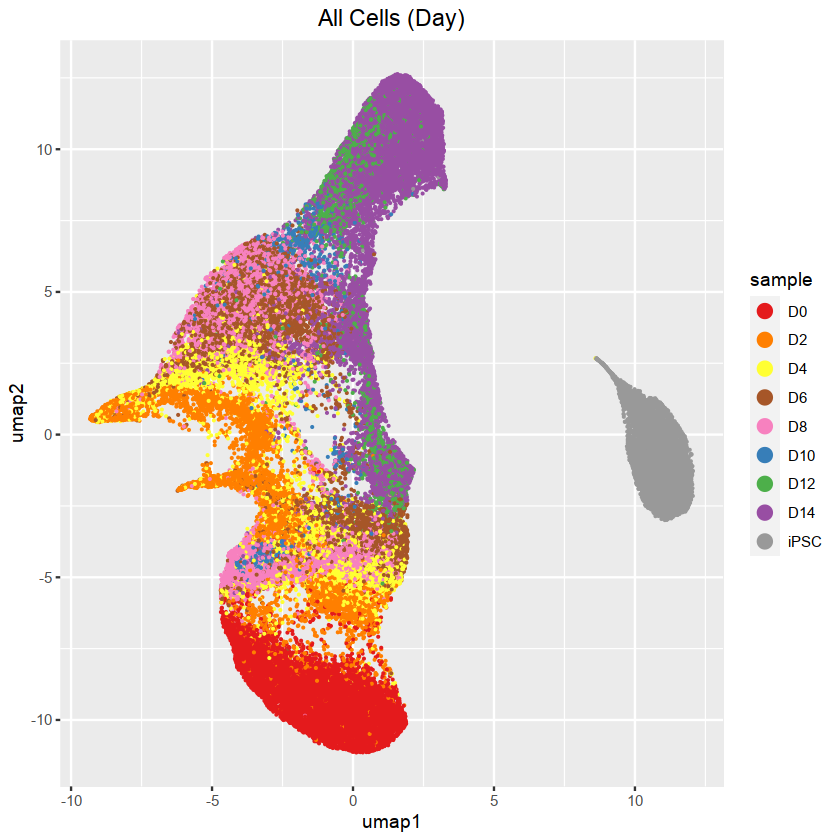

In [12]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2, 
                sample=metaData$sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Finer Clustering

In [13]:
library(RANN)
library(leiden)

In [14]:
feats = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/features.10d.tsv", header = T)
rownames(feats) = feats$sample_barcode
feats$sample_barcode = NULL
head(feats,3)

X1           X2          X3            X4         
D0_AAACACGCTAGTACGG -0.011152076 0.004344354  0.0002529584 0.008401771
D0_AAACACGCTCTTCAAG -0.009687992 0.003813404 -0.0019580142 0.002899934
D0_AAACACGCTGATCCAT -0.010974599 0.003615655  0.0003501312 0.004525435
                    X5          X6          X7            X8         
D0_AAACACGCTAGTACGG 0.008648427 0.010894021 -0.0094426710 0.007332589
D0_AAACACGCTCTTCAAG 0.006726516 0.021007651 -0.0007418293 0.004306952
D0_AAACACGCTGATCCAT 0.001075582 0.001667028 -0.0094977661 0.004310447
                    X9            X10        
D0_AAACACGCTAGTACGG -0.0010194442 0.004179675
D0_AAACACGCTCTTCAAG  0.0009223041 0.002109996
D0_AAACACGCTGATCCAT -0.0050801545 0.004722692

In [15]:
K = 15

nn.ranked <- nn2(
        data = feats,
        k = K,
        searchtype = 'standard',
        eps = 0)$nn.idx;

j <- as.numeric(x = t(x = nn.ranked))
i <- ((1:length(x = j)) - 1) %/% K + 1
edgeList = data.frame(i, j, 1);
kmat = Matrix(0, nrow(feats), nrow(feats), sparse=TRUE);
kmat = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);

In [27]:
clusters = leiden(kmat, resolution=5)

In [28]:
table(clusters)

clusters
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1823 1356 1346 1340 1280 1209 1201 1200 1197 1178 1171 1171 1168 1164 1151 1150 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
1127 1121 1097 1080 1077 1075 1060 1052 1046 1025  999  996  987  968  967  965 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 962  952  882  872  867  865  846  834  832  814  800  794  790  779  758  748 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
 724  719  703  687  678  671  669  647  634  627  613  610  568  551  538  524 
  65   66   67   68   69   70   71 
 471  469  439  309  236  220  150 

In [29]:
# write fine clusters to file
df = data.frame(sample_barcode=rownames(metaData), 
                clusters)
write.table(df, "../20200206_pmat_snapATAC/sessions/20210717_n62599/fine_clusters.tsv", 
            row.names = F, 
            quote = F)

In [30]:
# load fine clusters from file
# fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/fine_clusters.tsv", 
#             header = T)
# all(fine_clusters$sample_barcode==rownames(metaData))

# clusters = fine_clusters$clusters
# head(fine_clusters)

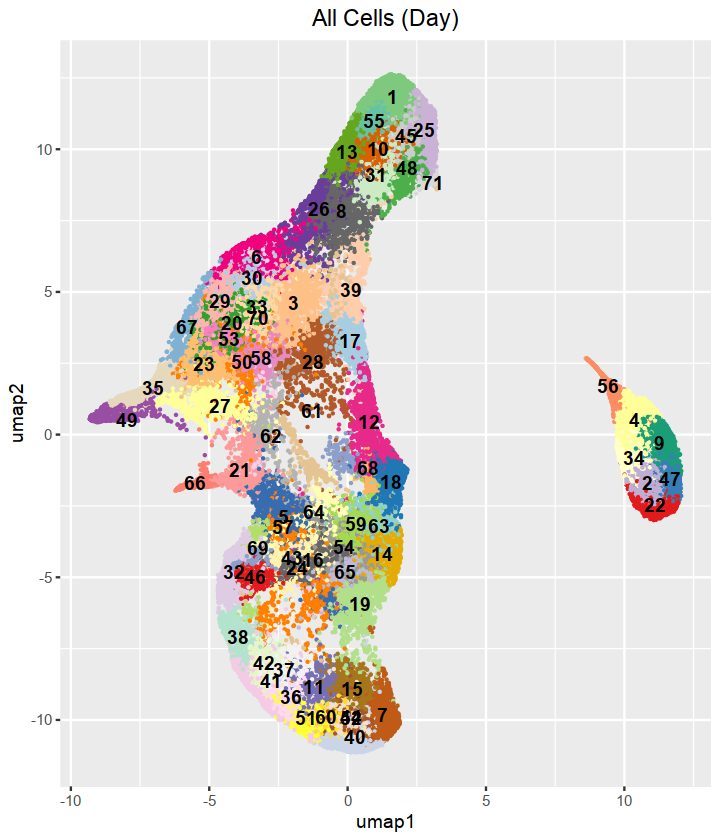

In [48]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=clst=)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap1","umap2")], 
                                    list(clusters), mean)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [51]:
# find ~pseudotime for cluster (average of days of cells in it)
# this is used to order peak sets later
# may be more accurate if done with pseudotime

# average of days
samp_to_time = seq(length(DAYS))
names(samp_to_time) = DAYS

cluster_to_pseudotime_avg = aggregate(samp_to_time[as.character(metaData$sample)], list(clusters), mean)

rownames(cluster_to_pseudotime_avg) = paste("cluster", cluster_to_pseudotime_avg$Group.1, sep="_")
cluster_to_pseudotime_avg$Group.1 = NULL
colnames(cluster_to_pseudotime_avg) = c("day_avg")
head(cluster_to_pseudotime_avg)

day_avg 
cluster_1 7.956665
cluster_2 9.000000
cluster_3 4.595840
cluster_4 9.000000
cluster_5 2.660156
cluster_6 4.736973

In [52]:
cluster_to_pseudotime_avg[1,]
cluster_to_pseudotime_avg[6,]

[1] 7.956665

[1] 4.736973

## Make pseudo-bulk matrix

In [53]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(pmat)))

In [54]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr17:32960817-32961317  1         12        7          7        6       
chr17:75764252-75764752 10        125       34        130       20       
chr17:1473114-1473614    6         48       30         29       19       
chr17:4206897-4207397    0          5        3          6        4       
chr17:423409-423909      0          9        8          8        2       
chr17:1964634-1965134    1          6        1          0        2       
                        cluster_6 cluster_7 cluster_8 cluster_9 cluster_10 ⋯
chr17:32960817-32961317  4         2         2         11        0         ⋯
chr17:75764252-75764752 44        67        16        149       14         ⋯
chr17:1473114-1473614   28         9         5         57        7         ⋯
chr17:4206897-4207397    2         5         1          4        0         ⋯
chr17:423409-423909      7         2         6         15        5         ⋯
chr17:1964634-1965134    0         1         1          4        1         ⋯
                        cluster_62 cluster_63 cluster_64 cluster_65 cluster_66
chr17:32960817-32961317  6          6          7          5          1        
chr17:75764252-75764752 15         24         22         23          4        
chr17:1473114-1473614    6          2          6          3         23        
chr17:4206897-4207397    1          3          2          5          2        
chr17:423409-423909      4          6          5          3          0        
chr17:1964634-1965134    0          0          0          1         11        
                        cluster_67 cluster_68 cluster_69 cluster_70 cluster_71
chr17:32960817-32961317 0          1          1          1          2         
chr17:75764252-75764752 6          8          2          4          3         
chr17:1473114-1473614   9          1          2          2          0         
chr17:4206897-4207397   1          0          2          0          0         
chr17:423409-423909     0          0          0          1          0         
chr17:1964634-1965134   0          0          0          0          0

[1] 530910     71

In [55]:
# removing smallest cluster since it has few cells and seem to be degenerate
# cts = cts[, 1:26]
# head(cts,2)

In [56]:
quantile(rowSums(cts), c(0, 0.02, 0.05,  0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1))

0%       2%       5%      10%      25%      50%      75%      90% 
   25.00   100.00   129.00   164.00   250.00   441.00  1001.00  2484.00 
     99%     100% 
12006.91 40619.00

In [57]:
sample(rownames(cts)[rowSums(cts)<quantile(rowSums(cts), 0.02)], 10)

[1] "chr9:87010550-87011050"    "chr20:60236080-60236580"  
 [3] "chr10:115674541-115675041" "chr20:9361205-9361705"    
 [5] "chr1:359048-359548"        "chr16:59701112-59701612"  
 [7] "chr7:88036344-88036844"    "chr1:160603723-160604223" 
 [9] "chr10:91719953-91720453"   "chr7:43000440-43000940"

In [59]:
# cts = cts[rowSums(cts)>quantile(rowSums(cts), 0.05), ]
# dim(cts)

In [60]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [61]:
log_norm_cts = log2(1+norm_cts)

In [63]:
# cts_to_cluster = log_norm_cts 

# scale counts by width of bin
cts_to_cluster = log2(1+501*(norm_cts/width(GRanges(rownames(norm_cts)))))

# z norm
# cts_to_cluster = t(scale(t(cts_to_cluster)))

# append z norm
znormed = t(scale(t(cts_to_cluster)))
colnames(znormed) = paste(colnames(znormed), "znorm", sep='_')
cts_to_cluster = cbind(cts_to_cluster, znormed)

In [ ]:
# ADD RAND SEED - not required
NUM_PEAK_SETS = 25
km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters = NUM_PEAK_SETS,
                        num_init = 50, 
                        verbose = FALSE)

### Routine to cluster centroids and reorder 

In [102]:
km_mb_centroids = km_mb$centroids[, 1:length(unique(clusters))]

In [103]:
min_pseudotime_cluster = rownames(cluster_to_pseudotime_avg)[order(cluster_to_pseudotime_avg)][1]
max_pseudotime_cluster = rownames(cluster_to_pseudotime_avg)[rev(order(cluster_to_pseudotime_avg))][1]

min_pseudotime_cluster_idx = which(colnames(cts_to_cluster)==min_pseudotime_cluster)
max_pseudotime_cluster_idx = which(colnames(cts_to_cluster)==max_pseudotime_cluster)


min_pseudotime_cluster
min_pseudotime_cluster_idx
max_pseudotime_cluster
max_pseudotime_cluster_idx

[1] "cluster_60"

[1] 60

[1] "cluster_47"

[1] 47

In [104]:
# separate low dispersion (var/mean) from high dispersion
NUM_LOW_DISP = 3 # number of low variance clusters, will be pulled out separately

order(rowVars(km_mb_centroids)/rowMeans(km_mb_centroids))
     
low_disp_idxs = sort(order(rowVars(km_mb_centroids)/rowMeans(km_mb_centroids))[1:NUM_LOW_DISP])
high_disp_idxs = sort(order(rowVars(km_mb_centroids)/rowMeans(km_mb_centroids))[NUM_LOW_DISP+1:nrow(km_mb_centroids)])

low_disp_idxs  # these will map to the last NUM_LOW_DISP idxs
high_disp_idxs # these will map to the first NUM_PEAK_SETS - NUM_LOW_DISP idxs

[1]  5 15 25  4  9 13  7 24 20  6  8 11 17  3 18 22  2  1 16 14 10 19 12 21 23

[1]  5 15 25

[1]  1  2  3  4  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24

In [105]:
# choose manually
# low_disp_idxs = c(5,18)
# high_disp_idxs = seq(NUM_PEAK_SETS)[!seq(NUM_PEAK_SETS) %in% low_disp_idxs]

# low_disp_idxs
# high_disp_idxs

In [106]:
# split high var into open-close, close-open, transient (add more)
CHANGE_LFC = log2(2) # base 2

open_close_peaks_idxs = sort(high_disp_idxs[(km_mb_centroids[high_disp_idxs, min_pseudotime_cluster_idx]-
                                  km_mb_centroids[high_disp_idxs, max_pseudotime_cluster_idx] > CHANGE_LFC)])
close_open_peaks_idxs = sort(high_disp_idxs[(km_mb_centroids[high_disp_idxs, max_pseudotime_cluster_idx]-
                                  km_mb_centroids[high_disp_idxs, min_pseudotime_cluster_idx] > CHANGE_LFC)])
transient_peaks_idxs = sort(high_disp_idxs[!(high_disp_idxs %in% 
                                             c(open_close_peaks_idxs, close_open_peaks_idxs))])


open_close_peaks_idxs
transient_peaks_idxs
close_open_peaks_idxs

[1]  3 11 14 17 22

[1]  1  4  6  7  9 10 12 20 21

[1]  2  8 13 16 18 19 23 24

In [107]:
# rough average pseudotime per cluster: accs weighted average of pseudotimes of each cluster
# will use this for ordering clusters after dendrogram (within each category [close-open, open-close, transient, low variabce])
cluster_avg_pseudotime = cluster_to_pseudotime_avg[colnames(cts_to_cluster)[1:length(unique(clusters))], "day_avg"]
centroid_pseudotimes = -rowSums(t(t(km_mb_centroids)*cluster_avg_pseudotime))/rowSums(km_mb_centroids)

In [108]:
reorder_index_set <- function(centroids, idxs, pseudotimes) {
    stopifnot(all(sort(idxs)==idxs))
    stopifnot(nrow(centroids)==length(pseudotimes)) # should not be indexed yet
    
    distance    = dist(centroids[idxs, ])
    cluster = hclust(distance, method="complete")
    dendrogram = as.dendrogram(cluster)
    
    # reorder based on average pseudotime of peak sets
    dendrogram = reorder(dendrogram, pseudotimes[idxs], mean)
    
    # old: new_to_old_map[i] -> new: i [but old go from 1..length(idxs), convert to actual idxs]
    new_to_old_map = rev(order.dendrogram(dendrogram))

    # replace with actual indxs (this works since idxs is sorted)
    new_to_old_map[order(new_to_old_map)] = idxs
    
    new_to_old_map
}

In [109]:
# km_mb$centroids will include the znormed parts
new_to_old_open_close = reorder_index_set(km_mb$centroids, open_close_peaks_idxs, centroid_pseudotimes)
new_to_old_transient = reorder_index_set(km_mb$centroids, transient_peaks_idxs, centroid_pseudotimes)
new_to_old_close_open = reorder_index_set(km_mb$centroids, close_open_peaks_idxs, centroid_pseudotimes)
new_to_old_low_disp = reorder_index_set(km_mb$centroids, low_disp_idxs, centroid_pseudotimes)

In [110]:
# options(repr.plot.width = 10, repr.plot.height = 7)
# ggdendrogram(dendrogram)

In [111]:
length(new_to_old_open_close)
length(new_to_old_transient)
length(new_to_old_close_open)
length(new_to_old_low_disp)

[1] 5

[1] 9

[1] 8

[1] 3

In [112]:
new_to_old_complete = c(new_to_old_open_close,
                       new_to_old_transient,
                       new_to_old_close_open,
                       new_to_old_low_disp)

In [113]:
# cluster assignments per peak
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

In [114]:
# reorder to new indices
pr_mb = order(new_to_old_complete)[pr_mb]

### If no reordering

In [115]:
# no hierarchical clustering, follow order of km_mb$centroids
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

---

In [116]:
sort(table(pr_mb))

pr_mb
    3    14     5    11    12    23    25    21    13    16    15    10    24 
 8832 10910 11342 14646 15292 15450 15860 17126 17724 17842 18153 19073 20672 
    4    18     9    19     8    22    20    17     2     1     6     7 
20691 21535 22363 22850 25513 27156 27819 28373 29328 30930 34806 36624 

In [117]:
cts_clustered = cts_to_cluster[order(pr_mb), 1:length(unique(clusters))] # divide when znormed pasted
head(cts_clustered, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr17:35115886-35116386 2.261808  2.054843  2.643365  1.908712  3.344241 
chr17:38486835-38487335 1.535038  1.532562  1.540184  1.651947  2.018618 
                        cluster_6 cluster_7 cluster_8 cluster_9 cluster_10 ⋯
chr17:35115886-35116386 1.297011  3.779808  0.000000  1.596828  2.232408   ⋯
chr17:38486835-38487335 0.979266  4.268455  2.046685  1.332611  2.232408   ⋯
                        cluster_62 cluster_63 cluster_64 cluster_65 cluster_66
chr17:35115886-35116386 3.987342   3.715958   4.186919   4.386012   0         
chr17:38486835-38487335 1.514768   1.886710   2.151422   2.741601   0         
                        cluster_67 cluster_68 cluster_69 cluster_70 cluster_71
chr17:35115886-35116386 3.100364   0.000000   3.741821   1.987997   0         
chr17:38486835-38487335 2.471398   2.318933   2.845820   2.793629   0

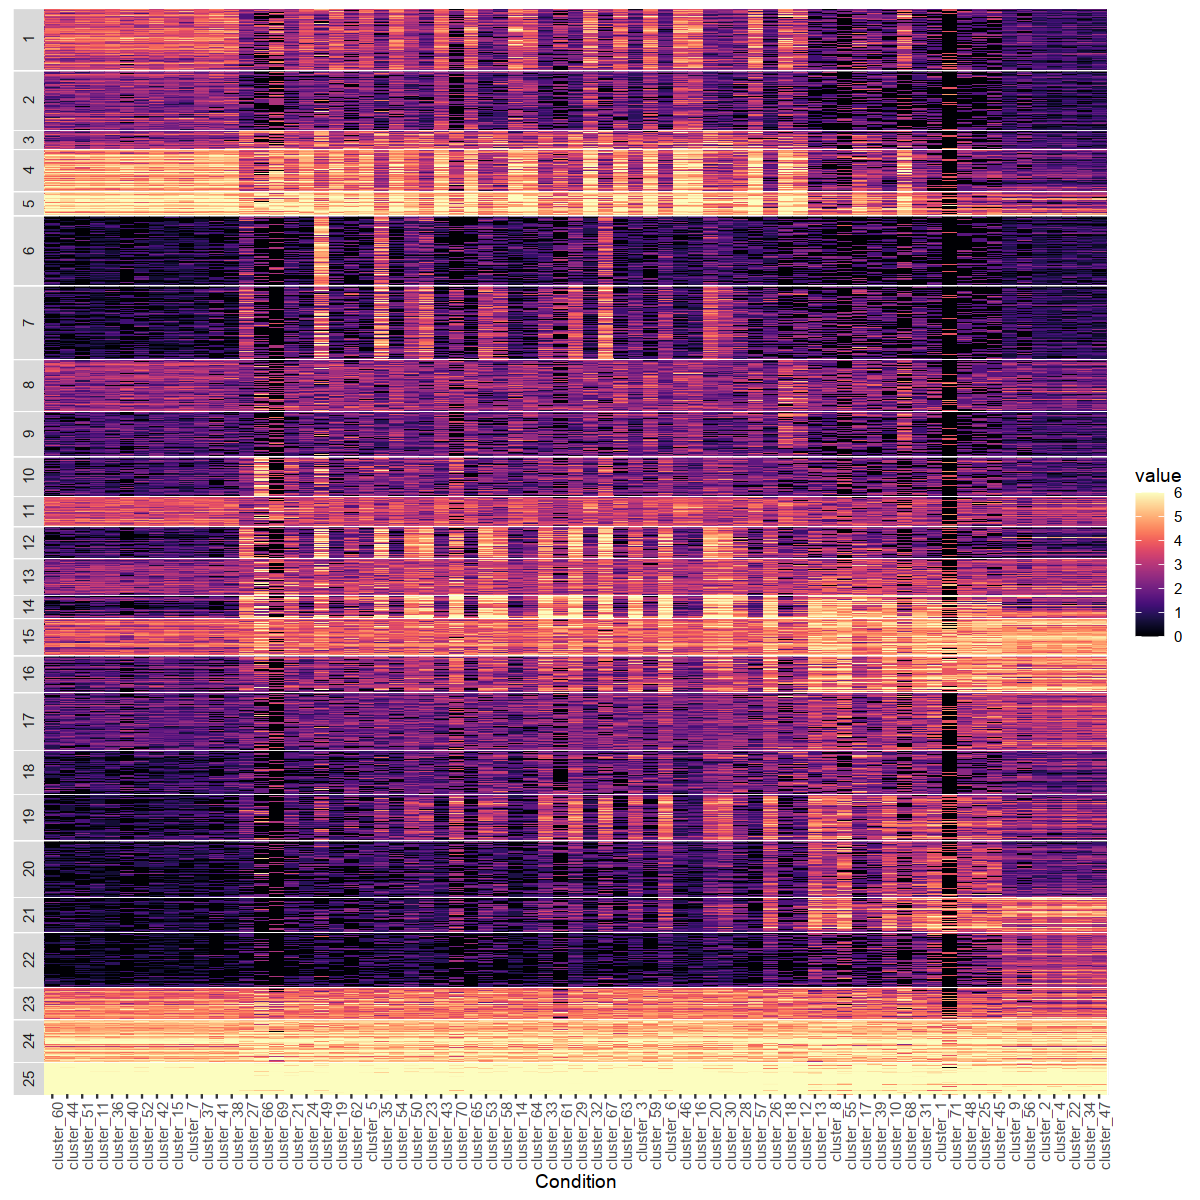

In [152]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 100) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = factor(Var2, 
                                levels=paste(rownames(cluster_to_pseudotime_avg)[order(cluster_to_pseudotime_avg$day_avg)])),
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 6), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.04, "cm"))
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

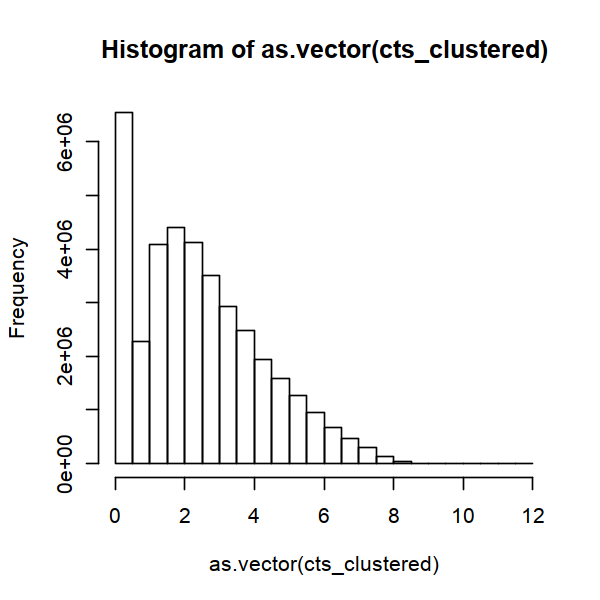

In [119]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

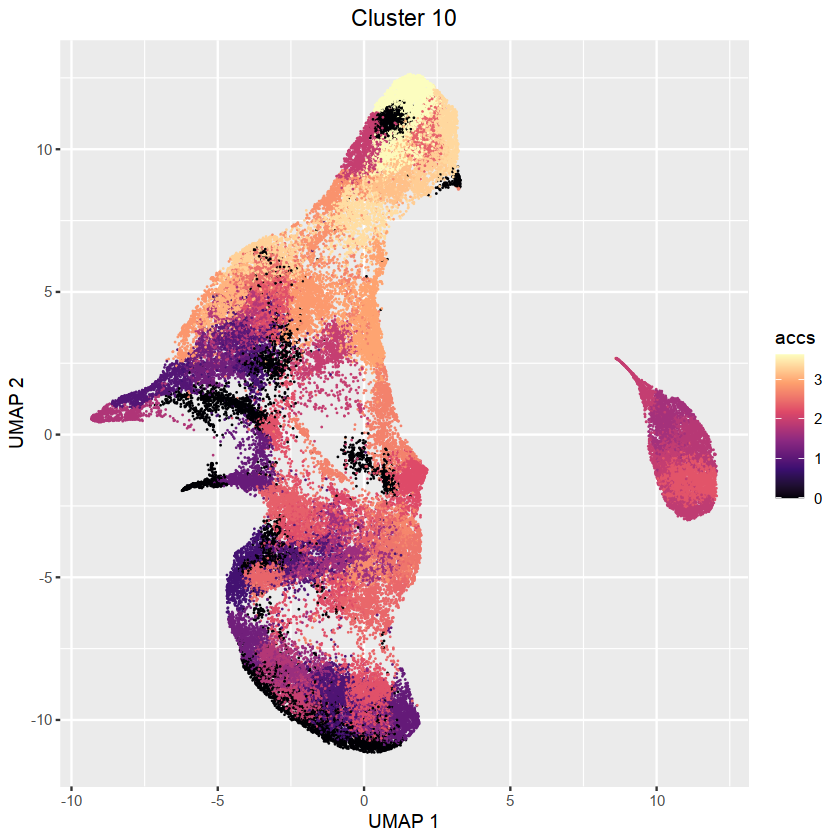

In [149]:
options(repr.plot.width = 7, repr.plot.height = 7)
selected_cluster_id = 10

# visualize a centroid
# df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])

# or a specific peak
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2, 
                accs=log2(1+norm_cts["chr11:64510709-64511209", ][clusters]))

# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke = 0,alpha=1, aes(x=umap1 , y=umap2, col=accs)) +
ggtitle(sprintf("Cluster %d", selected_cluster_id)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(#limits=c(0, 6),
                      oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5))

In [120]:
plots = list()
for (i in seq(1,NUM_PEAK_SETS)) {
    df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2, 
                    centroid_accs=km_mb$centroids[new_to_old_complete[i], ][clusters])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    plots[[i]] <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=0.8, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=centroid_accs)) +
    ggtitle(sprintf("Cluster %d", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(0,6), oob=squish, option = "A") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         axis.line=element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5))
}

In [121]:
# get legend
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                centroid_accs=km_mb$centroids[1, ][clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 20000), ]

cur_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=1, alpha=1, aes(x=umap1 , y=umap2, col=centroid_accs)) +
ggtitle(sprintf("Cluster %d", i)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, 6), oob=squish, option = "A") +
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank(),
     axis.line=element_blank(),
     panel.border = element_rect(colour = "black", fill=NA, size=0.5))

legend_only = cowplot::get_legend(cur_plot)

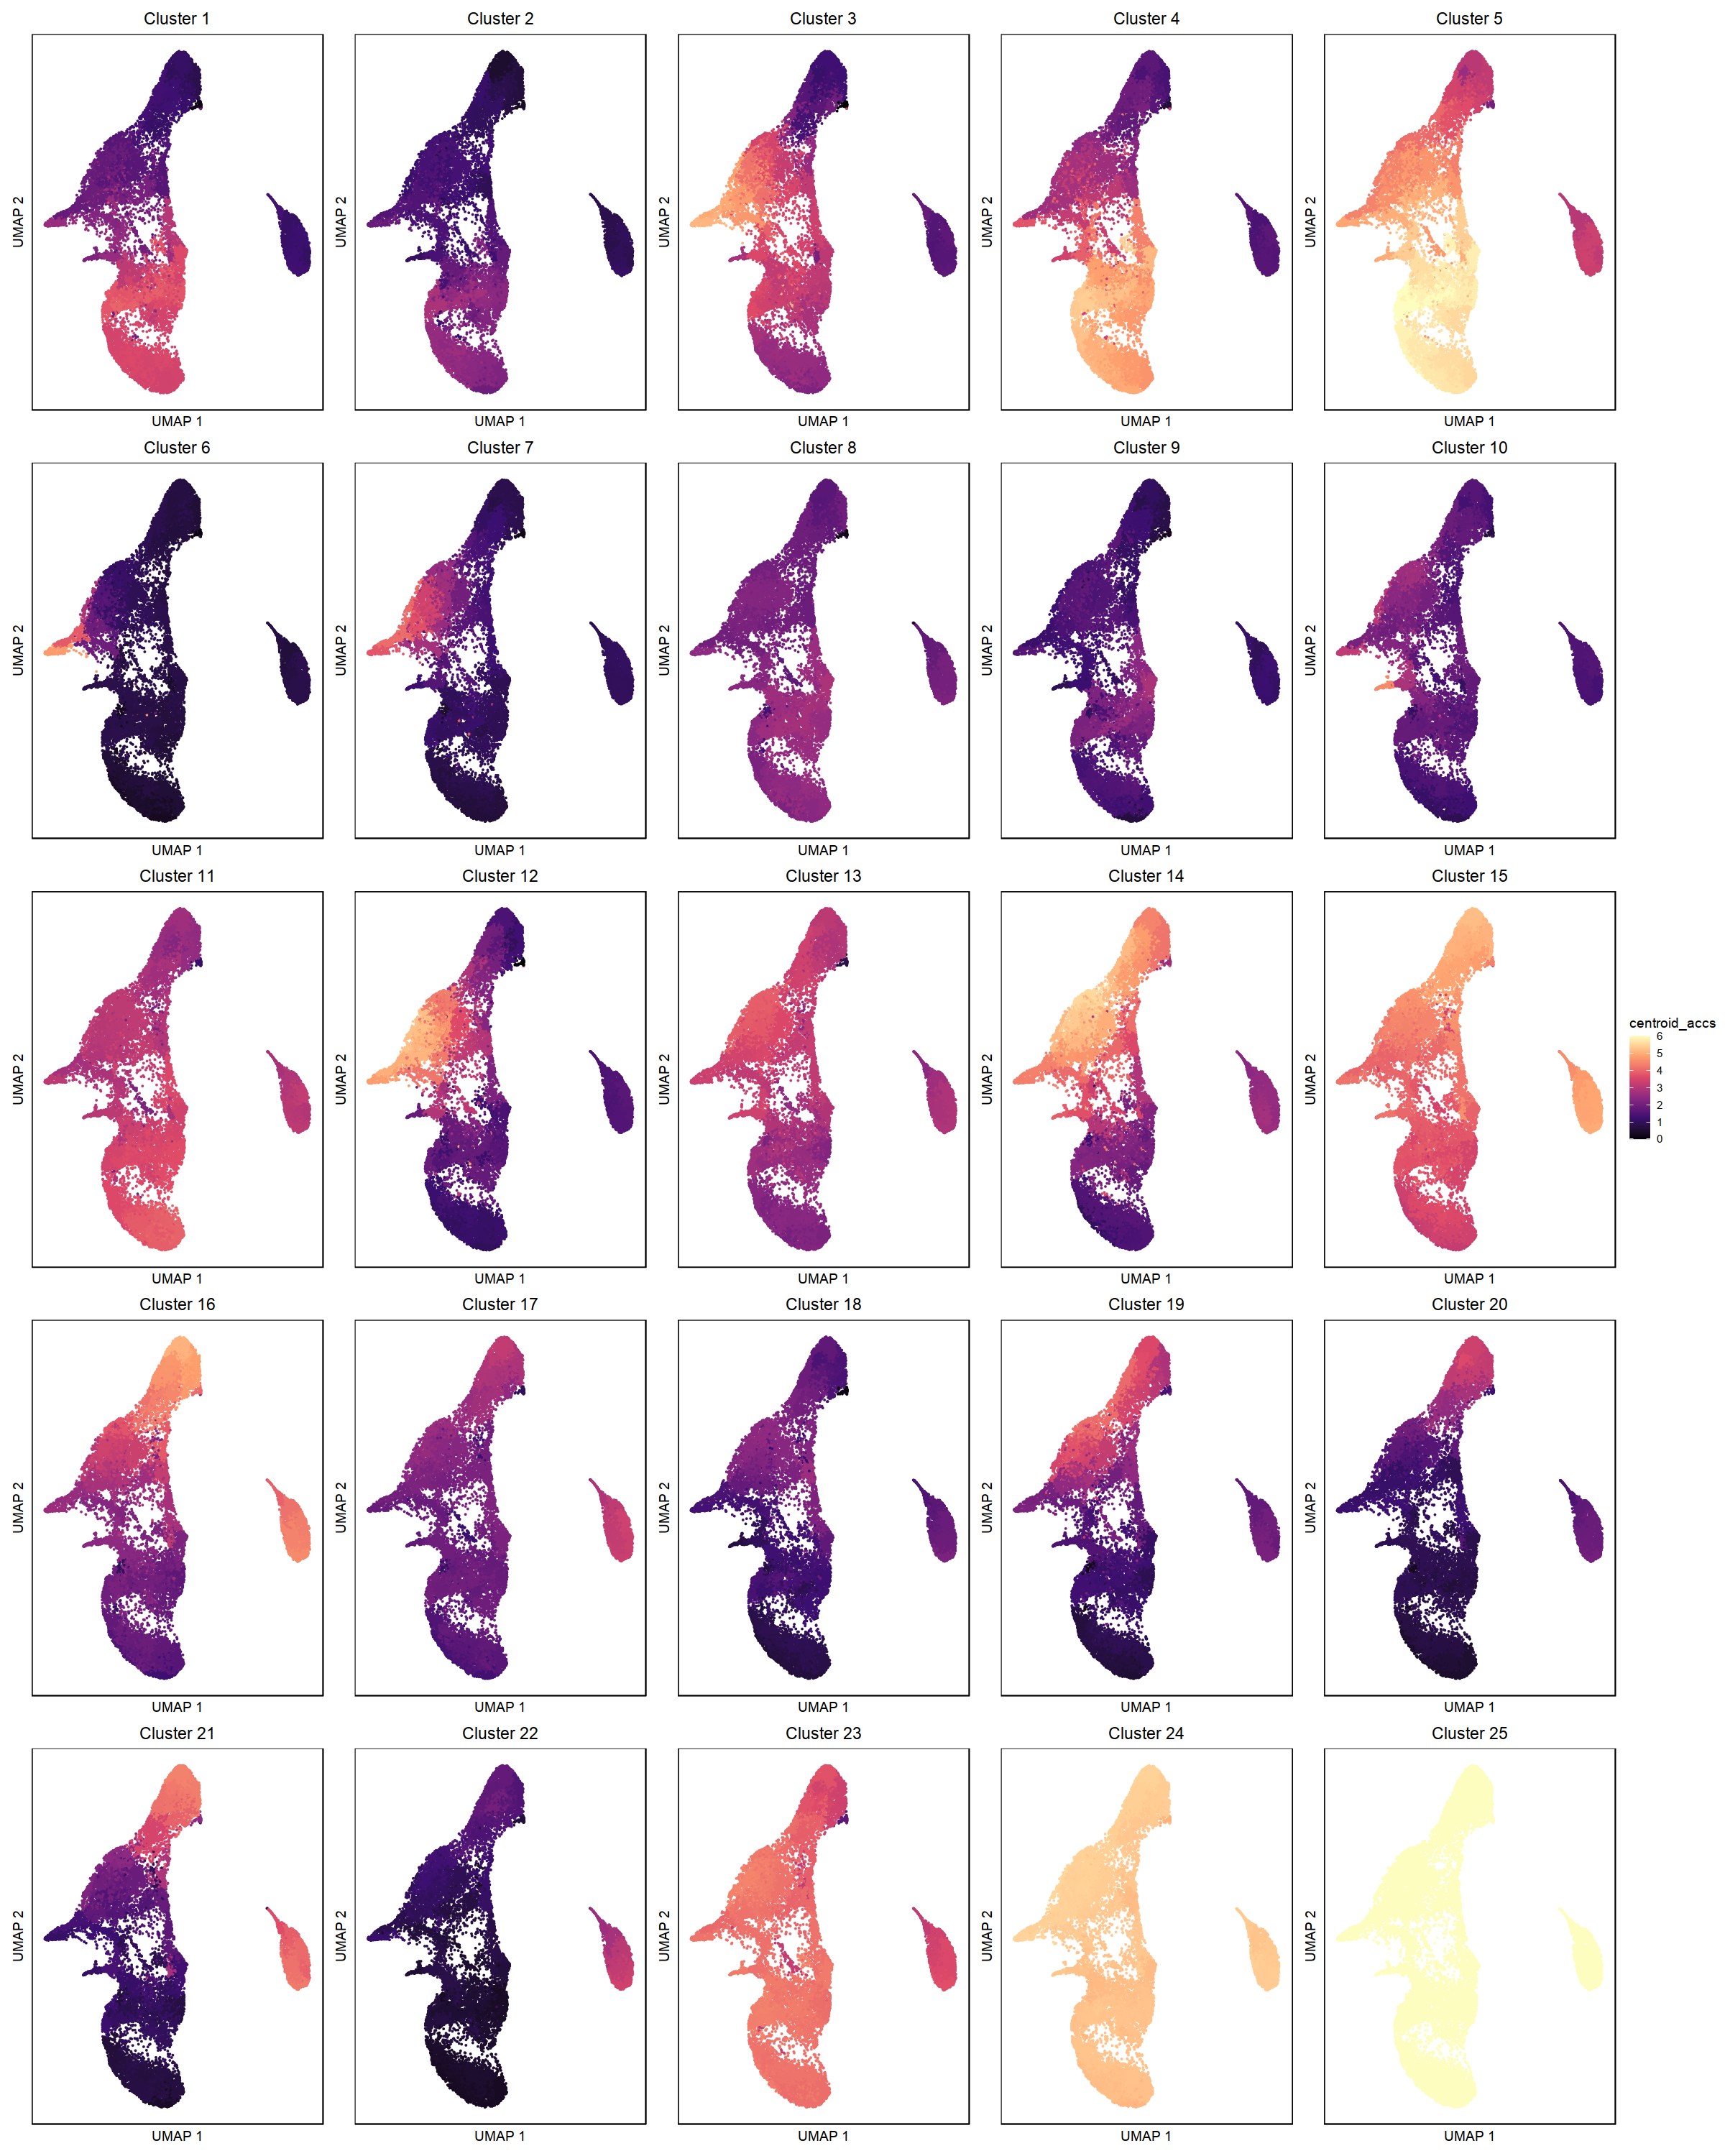

In [122]:
options(repr.plot.width = 20, repr.plot.height = 25)
wrap_plots(wrap_plots(plots, ncol = 5), legend_only, widths=c(0.95,0.05))  
# ggsave(sprintf("figs/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/log_cts.jpeg"),
# #                format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        width=20, height=40, dpi=300)

## Writing BED files for Peak Sets

In [123]:
CLUSTER_IDX = 1
NORM = 'gridmap_peakwidthnorm_logplusznorm_4way_ordered'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20210718_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n25/idx1.bed"

In [124]:
peak_formatted = sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))

In [125]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(peak_formatted[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [126]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(peak_formatted, fileConn)
close(fileConn)

[1] "beds/20210718_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n25/all_peaks.bed"


## Fraction in Peak Plots

For each peak set, plot graphs similar to above but instead with fraction of reads in peak set for each single cell.

In [127]:
pmatRowSums = Matrix::rowSums(pmat)

In [128]:
peaks_gr = makeGRangesFromDataFrame(data.frame(chr=regions$chr,
                                   start=regions$bp1,
                                   end=regions$bp2))

In [129]:
plots = list()
for (i in seq(1,25)) {
    fname = sprintf("./beds/20210718_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n25/idx%d.bed", i)
    region_gr = read.table(fname)

    colnames(region_gr) = c("chr", "start", "end")
    region_gr = makeGRangesFromDataFrame(region_gr)
    
    norm_reads_in_region = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peaks_gr, region_gr)))])/pmatRowSums
    
    df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=100*norm_reads_in_region)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 30000), ]

    plots[[i]] = ggplot(df) +
    # ggplot(df[df$percent_reads<2, ]) +
    geom_point(size=0.5, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
    ggtitle(sprintf("Peak Set %d \n (%d peaks)",  
                   i, length(region_gr))) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits= c(0, 
                                  quantile(100*norm_reads_in_region, 0.99)), 
                          oob=squish, option = "B") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5))
}

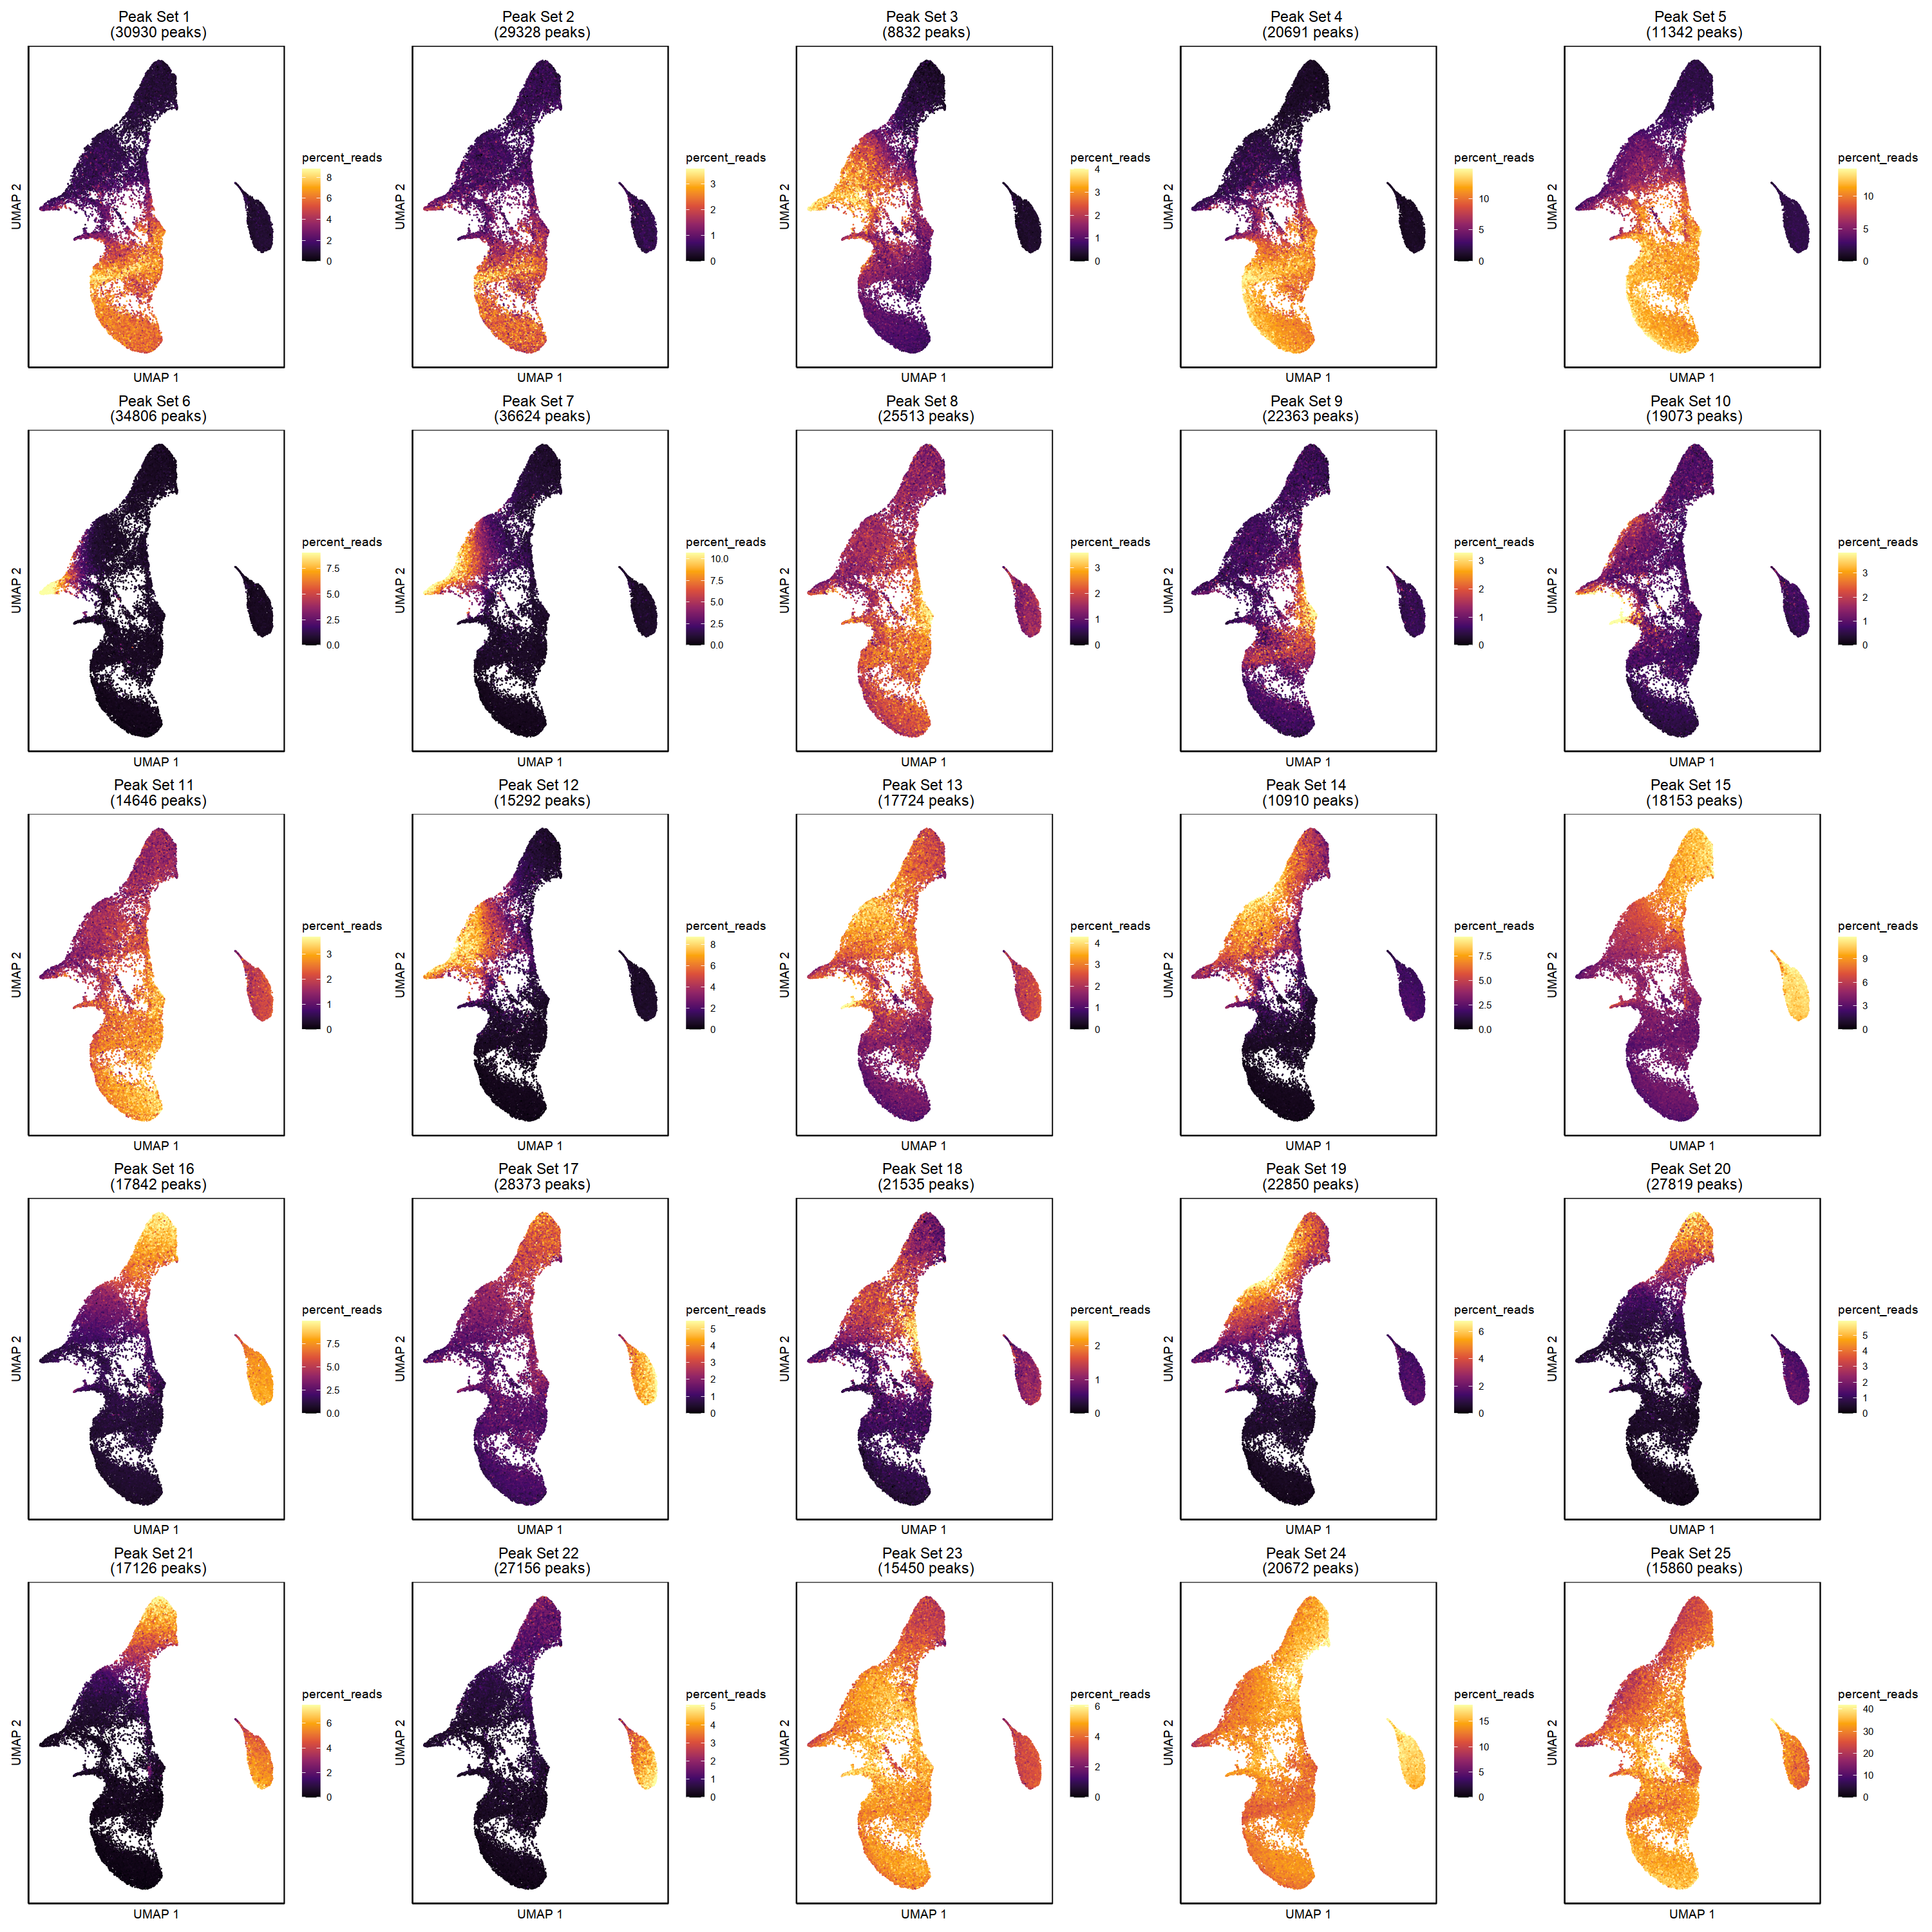

In [130]:
options(repr.plot.width = 25, repr.plot.height = 25)
wrap_plots(plots, ncol = 5) 
# ggsave(sprintf("figs/%s_gridmap_peakwidthnorm_sc_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        width=30, height=35, dpi=300)

In [99]:
# options(repr.plot.width = 25, repr.plot.height = 5)
# wrap_plots(list(plots[[5]], plots[[11]], plots[[20]], plots[[18]], plots[[19]]), ncol = 5)

In [100]:
# options(repr.plot.width = 25, repr.plot.height = 5)
# wrap_plots(list(plots[[13]], plots[[14]], plots[[17]], plots[[10]], plots[[16]]), ncol = 5)

In [101]:
# options(repr.plot.width = 15, repr.plot.height = 10)
# wrap_plots(list(plots[[2]], plots[[12]], plots[[9]], plots[[7]], plots[[1]], plots[[15]]), ncol = 3)

---

In [100]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] leiden_0.3.3                RANN_2.6.1                 
 [3] ggdendro_0.1-20             Matrix_1.2-18              
 [5] cowplot_1.0.0               patchwork_1.0.0            
 [7] RColorBrewer_1.1-2          ClusterR_1.2.2             
 [9] gtools_3.8.2              

---

## GREAT Analysis

This can be ignored.

In [43]:
library(rGREAT)


------------------
Note: On Aug 19 2019 GREAT released version 4 where it supports `hg38`
genome and removes some ontologies such pathways. `submitGreatJob()`
still takes `hg19` as default. `hg38` can be specified by the `species
= 'hg38'` argument. To use the older versions such as 3.0.0, specify as
`submitGreatJob(..., version = '3.0.0')`.
------------------



In [96]:
peaks = read.table("beds/20200330_gridmap_peakwidthnorm_n20/idx1.bed")
colnames(peaks) = c("chr", "start", "end")
peaks = makeGRangesFromDataFrame(peaks)
peaks

GRanges object with 21314 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1       51689-52109      *
      [2]     chr1   2083154-2083354      *
      [3]     chr1   2148793-2149289      *
      [4]     chr1   2149338-2149538      *
      [5]     chr1   2802094-2802294      *
      ...      ...               ...    ...
  [21310]     chrY 20929733-20930029      *
  [21311]     chrY 20949541-20949741      *
  [21312]     chrY 20949820-20950020      *
  [21313]     chrY 21310322-21310522      *
  [21314]     chrY 22373656-22373856      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [97]:
bg = read.table("beds/20200330_gridmap_peakwidthnorm_n20/all_peaks.bed")
colnames(bg) = c("chr", "start", "end")
bg = makeGRangesFromDataFrame(bg)
bg

GRanges object with 457477 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       16147-16347      *
       [2]     chr1       51689-52109      *
       [3]     chr1     180686-181260      *
       [4]     chr1     181268-181597      *
       [5]     chr1     184385-184585      *
       ...      ...               ...    ...
  [457473]     chrY 21310322-21310522      *
  [457474]     chrY 22373656-22373856      *
  [457475]     chrY 26670497-26671505      *
  [457476]     chrY 56728041-56728241      *
  [457477]     chrY 56734685-56734895      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [98]:
# if background does not contain peaks
bg = do.call("c", list(peaks, bg))

In [99]:
# job = submitGreatJob(peaks, species = "hg38", request_interval = 10)
job = submitGreatJob(peaks, bg=bg, species = "hg38", request_interval = 10)

In [100]:
job

Submit time: 2020-04-16 00:08:18 
Version: 4.0.4 
Species: hg38 
Inputs: 21314 regions
Background: user-defined, 478791 regions
Model: Basal plus extension 
  Proximal: 5 kb upstream, 1 kb downstream,
  plus Distal: up to 1000 kb
Include curated regulatory domains

Enrichment tables for following ontologies have been downloaded:
  None


In [101]:
tb = getEnrichmentTables(job)
names(tb)

[1] "GO Molecular Function" "GO Biological Process" "GO Cellular Component"

In [ ]:
# head(tb[[2]][tb[[2]]$Hyper_Fold_Enrichment>1, c(1,2,3,4,6,13)], 30)
head(tb[[2]][(tb[[2]]$Hyper_Expected<5000)&(tb[[2]]$Hyper_Expected>50)&(tb[[2]]$Hyper_Fold_Enrichment>1), c(1,2,3,4,6,13)], 20)

# head(tb[[2]][(tb[[2]]$Binom_Expected<1000)&(tb[[2]]$Binom_Fold_Enrichment>2)&(tb[[2]]$Hyper_Adjp_BH<0.05)&(tb[[2]]$Binom_Adjp_BH<0.05), ], 30)
# head(tb[[2]], 30)